In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.collocations import *
import re
import nltk

%matplotlib inline

In [2]:
user_reviews_df = pd.read_csv("./Data/user_reviews.csv")

In [3]:
# Looking at the data from the 
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598158 entries, 0 to 598157
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  598158 non-null  int64 
 1   user_id     598158 non-null  int64 
 2   recipe_id   598158 non-null  int64 
 3   date        598158 non-null  object
 4   rating      598158 non-null  int64 
 5   review      598154 non-null  object
dtypes: int64(4), object(2)
memory usage: 27.4+ MB


In [4]:
#Drop 4 missing reviews
user_reviews_df.dropna(inplace=True)

In [5]:
# Drop Unnamed: 0 column
user_reviews_df.drop("Unnamed: 0", axis=1, inplace=True)
user_reviews_df

,user_id,recipe_id,date,rating,review
0,76535,134728,2005-09-02,4,Very good!
1,190375,134728,2007-03-09,5,These taste absolutely wonderful!! My son-in-...
2,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
3,255338,134728,2008-04-11,5,First time using liquid smoke in a recipe. Mad...
4,1171894,134728,2009-04-21,5,MMMMM! This is so good! I actually soaked the ...
...,...,...,...,...,...
598153,496803,249924,2011-08-21,5,I really loved this! I cut the recipe back to...
598154,143592,82303,2010-07-26,5,I will never buy hot fudge again. This is so q...
598155,140132,82303,2010-10-01,5,This is fabulous. I made it for our dessert t...
598156,199020,82303,2013-03-18,5,5 stars for taste! I had a hard time getting m...


In [6]:
#Check no missing values
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 0 to 598157
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    598154 non-null  int64 
 1   recipe_id  598154 non-null  int64 
 2   date       598154 non-null  object
 3   rating     598154 non-null  int64 
 4   review     598154 non-null  object
dtypes: int64(3), object(2)
memory usage: 27.4+ MB


In [7]:
#Turn user_id, recipe_id to string
user_reviews_df["review"] = user_reviews_df["review"].astype(str)
user_reviews_df["user_id"] = user_reviews_df["user_id"].astype(str)
user_reviews_df["recipe_id"] = user_reviews_df["recipe_id"].astype(str)

In [9]:
#Turn rating into a float
user_reviews_df["rating"] = user_reviews_df["rating"].astype(float)

In [10]:
#Check that the changes worked
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 0 to 598157
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    598154 non-null  object 
 1   recipe_id  598154 non-null  object 
 2   date       598154 non-null  object 
 3   rating     598154 non-null  float64
 4   review     598154 non-null  object 
dtypes: float64(1), object(4)
memory usage: 27.4+ MB


## Visualizing Rating Data

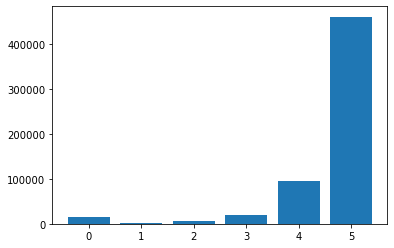

In [12]:
#Creating a bar chart to see the distribution of ratings
rating_count = user_reviews_df["rating"].value_counts().sort_index(ascending=False)

plt.bar(rating_count.index, rating_count.values);

In [15]:
rating_count

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
0.0     14693
Name: rating, dtype: int64

77% of our new dataset includes 5 star reviews, which heavily skews the data and will affect the recommendation portal. 

We also notice that 2.4% of our dataset includes a 0 rating. It would be important to see if these are actually 0s or if they are imputed value for missing ratings. 

In [16]:
#Looking at the 0 ratings to see if they are actually 0s or missing ratings
user_reviews_df.loc[user_reviews_df["rating"] == 0]

,user_id,recipe_id,date,rating,review
2,468945,134728,2008-02-20,0.0,Made my own buttermilk w/ vinegar and milk. U...
7,681408,225241,2008-03-14,0.0,This is a very good recipe. We also want to c...
19,980899,79222,2010-10-18,0.0,"I used half cream and half 1% milk, added anot..."
205,93911,306919,2010-07-08,0.0,I haven't tried this recipe so I'm not rating ...
249,921361,232042,2014-10-03,0.0,Tasted great and was super easy to make. Thank...
...,...,...,...,...,...
597902,194886,99731,2013-01-24,0.0,"This is a great recipe, I thought I had review..."
597914,113509,130019,2012-04-20,0.0,Hubby and I thought this was good. Neither of ...
597986,374506,39724,2008-03-19,0.0,Great!!! After the turkey was done I browned t...
598000,329378,39902,2006-10-19,0.0,"While the recipe calls for 3 cups of cheese, t..."


It looks like the 0s are both a mix of positive and negative (or neutral reviews). While it is a small subset of our dataset it could be important to include these reviews considering the skew of our data. We could impute ratings based on the language used in the "review" column using KNN Imputer, but this could lead to data leakage concerns and long processing times. In this case we will just drop these data points.

In [19]:
#Dropping rating that are 0 
#df.drop(df.loc[df['line_race']==0].index, inplace=True)
user_reviews_df.drop(user_reviews_df.loc[user_reviews_df["rating"]==0].index, inplace=True)
#user_reviews_df.loc[user_reviews_df["rating"] == 0].drop(inplace=True)

In [20]:
#Check thaat the 0s are gone
user_reviews_df["rating"].value_counts()

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
Name: rating, dtype: int64

In [22]:
#Need to recheck that our recipes all have five ratings
user_reviews_df["recipe_id"].value_counts()

27208     1009
89204      979
32204      826
39087      825
69173      740
          ... 
291604       1
139          1
145738       1
344788       1
123821       1
Name: recipe_id, Length: 53127, dtype: int64

In [23]:
len(user_reviews_df["recipe_id"].value_counts())

53127

In [24]:
# Creating a list of recipe_review_counts for each recipe
# Remove recipes with less than 5 review counts

recipe_review_counts = user_reviews_df["recipe_id"].value_counts()

user_reviews_df = user_reviews_df[user_reviews_df["recipe_id"].isin(recipe_review_counts[recipe_review_counts >= 5].index)]

# Check that recipes with under 5 reviews were removed

len(user_reviews_df["recipe_id"].value_counts())


40527

In [27]:
40527/53127

0.7628324580721667

In [25]:
# Checking the amount of reviews per user. 
# For recommendation modeling we need at least 5 reviews per reader. 

user_reviews_df["user_id"].value_counts()

37449         2789
383346        2396
424680        2145
128473        2024
89831         1893
              ... 
2454797          1
713301           1
578380           1
467510           1
2001522017       1
Name: user_id, Length: 18943, dtype: int64

In [26]:
# Create a list review counts for each user 
# Keep only those with more than 5 in the dataframe 
review_counts = user_reviews_df["user_id"].value_counts()
user_reviews_df = user_reviews_df[user_reviews_df["user_id"].isin(review_counts[review_counts >= 5].index)]

# Check that users with under 5 reviews were removed
len(user_reviews_df["user_id"].value_counts())

17096

In [28]:
17096/18943

0.9024969645779444

We lost a fair bit more of our data - about 25% of our recipes - and 10% of our users, but now we make sure we have users with at least five reviews. 

In [29]:
#Save off as a csv file
#user_reviews_df.to_csv("./Data/user_reviews_no_zero.csv")